In [ ]:
!git clone https://github.com/bethgelab/model-vs-human.git

Cloning into 'model-vs-human'...
remote: Enumerating objects: 733, done.
remote: Counting objects: 100% (225/225), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 733 (delta 163), reused 141 (delta 140), pack-reused 508
Receiving objects: 100% (733/733), 27.05 MiB | 12.13 MiB/s, done.
Resolving deltas: 100% (333/333), done.


In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import torch
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

from google.colab import drive
drive.mount('/content/drive')


import pandas as pd


from google.colab import auth

auth.authenticate_user()

project_id = 'beyond-dl-1503610372419'
!gcloud config set project {project_id}

!pip install -q git+https://github.com/openai/CLIP#egg=CLIP
!pip install -q pytorch_pretrained_vit
!pip install git+https://github.com/bethgelab/model-vs-human --no-deps
!pip install git+https://github.com/bethgelab/model-vs-human --no-deps

!pip install -q captum
import captum
from captum.attr import LayerGradCam 


def set_size(w,h):
  """Set matplot figure size"""
  plt.rcParams["figure.figsize"] = [w,h]

def show(img, p=False, smooth=False, **kwargs):
  """ Display torch/tf tensor """ 
  try:
    img = img.detach().cpu()
  except:
    img = np.array(img)
  
  img = np.array(img, dtype=np.float32)

  # check if channel first
  if img.shape[0] == 1:
    img = img[0]
  elif img.shape[0] == 3:
    img = np.moveaxis(img, 0, -1)
  # check if cmap
  if img.shape[-1] == 1:
    img = img[:,:,0]
  # normalize
  if img.max() > 1 or img.min() < 0:
    img -= img.min(); img/=img.max()
  # check if clip percentile
  if p is not False:
    img = np.clip(img, np.percentile(img, p), np.percentile(img, 100-p))
  
  if smooth and len(img.shape) == 2:
    img = gaussian_filter(img, smooth)

  plt.imshow(img, **kwargs)
  plt.axis('off')
  plt.grid(None)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Updated property [core/project].
  Cloning https://github.com/bethgelab/model-vs-human to /tmp/pip-req-build-m3kufyee
  Running command git clone -q https://github.com/bethgelab/model-vs-human /tmp/pip-req-build-m3kufyee
  Cloning https://github.com/bethgelab/model-vs-human to /tmp/pip-req-build-072yc85r
  Running command git clone -q https://github.com/bethgelab/model-vs-human /tmp/pip-req-build-072yc85r


In [ ]:

try:
  import modelvshuman
except:
  pass

import modelvshuman
from modelvshuman import models

print(models.list_models("pytorch"))
print(models.list_models("tensorflow"))

for m in models.list_models("pytorch"):
  print(m)


['resnet50_trained_on_SIN', 'resnet50_trained_on_SIN_and_IN', 'resnet50_trained_on_SIN_and_IN_then_finetuned_on_IN', 'bagnet9', 'bagnet17', 'bagnet33', 'simclr_resnet50x1_supervised_baseline', 'simclr_resnet50x4_supervised_baseline', 'simclr_resnet50x1', 'simclr_resnet50x2', 'simclr_resnet50x4', 'InsDis', 'MoCo', 'MoCoV2', 'PIRL', 'InfoMin', 'resnet50_l2_eps0', 'resnet50_l2_eps0_01', 'resnet50_l2_eps0_03', 'resnet50_l2_eps0_05', 'resnet50_l2_eps0_1', 'resnet50_l2_eps0_25', 'resnet50_l2_eps0_5', 'resnet50_l2_eps1', 'resnet50_l2_eps3', 'resnet50_l2_eps5', 'efficientnet_b0', 'efficientnet_es', 'efficientnet_b0_noisy_student', 'efficientnet_l2_noisy_student_475', 'transformer_B16_IN21K', 'transformer_B32_IN21K', 'transformer_L16_IN21K', 'transformer_L32_IN21K', 'vit_small_patch16_224', 'vit_base_patch16_224', 'vit_large_patch16_224', 'cspresnet50', 'cspresnext50', 'cspdarknet53', 'darknet53', 'dpn68', 'dpn68b', 'dpn92', 'dpn98', 'dpn131', 'dpn107', 'hrnet_w18_small', 'hrnet_w18_small', 'h

In [ ]:
!cp "/content/drive/MyDrive/Paper Meta-predictor machine/data/clickme/clickme_val.tfrecords" ./

In [ ]:
AUTO = tf.data.AUTOTUNE
BLUR_KERNEL_SIZE = 10
BLUR_SIGMA = 10

_feature_description = {
      "image"       : tf.io.FixedLenFeature([], tf.string, default_value=''),
      "heatmap"     : tf.io.FixedLenFeature([], tf.string, default_value=''),
      "label"       : tf.io.FixedLenFeature([], tf.int64, default_value=0),
}

def _gaussian_kernel(size, sigma):
  x_range = tf.range(-(size-1)//2, (size-1)//2 + 1, 1)
  y_range = tf.range((size-1)//2, -(size-1)//2 - 1, -1)

  xs, ys = tf.meshgrid(x_range, y_range)
  kernel = tf.exp(-(xs**2 + ys**2)/(2*(sigma**2))) / (2*np.pi*(sigma**2))

  kernel = tf.cast(kernel / tf.reduce_sum(kernel), tf.float32)

  return tf.expand_dims(tf.expand_dims(kernel, axis=-1), axis=-1)

GAUSSIAN_KERNEL = tf.cast(_gaussian_kernel(BLUR_KERNEL_SIZE, BLUR_SIGMA), tf.float32)

def _gaussian_blur(heatmap):
    heatmap = tf.nn.conv2d(heatmap[None, :, :, :], GAUSSIAN_KERNEL, [1, 1, 1, 1], 'SAME')
    #heatmap = tf.nn.conv2d(heatmap, GAUSSIAN_KERNEL, [1, 1, 1, 1], 'SAME')
    #heatmap = tf.nn.conv2d(heatmap, GAUSSIAN_KERNEL, [1, 1, 1, 1], 'SAME')
    return heatmap[0]

def _random_crop(image, heatmap):
  seed = tf.random.uniform([2], maxval=10_000, dtype=tf.int32)
  crop_size = tf.random.uniform([], minval=224, maxval=256, dtype=tf.int32)
  
  cropped_image   = tf.image.stateless_random_crop(image, (crop_size, crop_size, 3), seed=seed)
  cropped_heatmap = tf.image.stateless_random_crop(heatmap, (crop_size, crop_size, 1), seed=seed)

  return cropped_image, cropped_heatmap


def parse_prototype(prototype, training=False):
  data    = tf.io.parse_single_example(prototype, _feature_description)

  image   = tf.io.decode_raw(data['image'], tf.float32)
  image   = tf.reshape(image, (256, 256, 3))
  image   = tf.cast(image, tf.float32)
  
  #heatmap = tf.io.decode_jpeg(data['heatmap'])
  heatmap = tf.io.decode_raw(data['heatmap'], tf.float32)
  heatmap = tf.reshape(heatmap, (256, 256, 1))

  image   = tf.image.resize(image, (224, 224), method='bilinear')
  image   = tf.cast(image, tf.float32)

  heatmap = tf.cast(heatmap, tf.float32)
  heatmap = tf.image.resize(heatmap, (64, 64), method="bilinear")
  heatmap = _gaussian_blur(heatmap)
  heatmap = tf.image.resize(heatmap, (224, 224), method="bilinear")
  heatmap = tf.cast(heatmap, tf.float32)

  label   = tf.cast(data['label'], tf.int32)
  label   = tf.one_hot(label, 1_000)

  return image, heatmap, label

def get_dataset(batch_size, training=False):
    deterministic_order = tf.data.Options()
    deterministic_order.experimental_deterministic = True

    dataset = tf.data.TFRecordDataset(['/content/clickme_val.tfrecords'], num_parallel_reads=AUTO)
    dataset = dataset.with_options(deterministic_order) 
      
    dataset = dataset.map(parse_prototype, num_parallel_calls=AUTO)
    
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(AUTO)

    return dataset

In [ ]:
imagenet_classes = ["tench", "goldfish", "great white shark", "tiger shark", "hammerhead shark", "electric ray", "stingray", "rooster", "hen", "ostrich", "brambling", "goldfinch", "house finch", "junco", "indigo bunting", "American robin", "bulbul", "jay", "magpie", "chickadee", "American dipper", "kite (bird of prey)", "bald eagle", "vulture", "great grey owl", "fire salamander", "smooth newt", "newt", "spotted salamander", "axolotl", "American bullfrog", "tree frog", "tailed frog", "loggerhead sea turtle", "leatherback sea turtle", "mud turtle", "terrapin", "box turtle", "banded gecko", "green iguana", "Carolina anole", "desert grassland whiptail lizard", "agama", "frilled-necked lizard", "alligator lizard", "Gila monster", "European green lizard", "chameleon", "Komodo dragon", "Nile crocodile", "American alligator", "triceratops", "worm snake", "ring-necked snake", "eastern hog-nosed snake", "smooth green snake", "kingsnake", "garter snake", "water snake", "vine snake", "night snake", "boa constrictor", "African rock python", "Indian cobra", "green mamba", "sea snake", "Saharan horned viper", "eastern diamondback rattlesnake", "sidewinder rattlesnake", "trilobite", "harvestman", "scorpion", "yellow garden spider", "barn spider", "European garden spider", "southern black widow", "tarantula", "wolf spider", "tick", "centipede", "black grouse", "ptarmigan", "ruffed grouse", "prairie grouse", "peafowl", "quail", "partridge", "african grey parrot", "macaw", "sulphur-crested cockatoo", "lorikeet", "coucal", "bee eater", "hornbill", "hummingbird", "jacamar", "toucan", "duck", "red-breasted merganser", "goose", "black swan", "tusker", "echidna", "platypus", "wallaby", "koala", "wombat", "jellyfish", "sea anemone", "brain coral", "flatworm", "nematode", "conch", "snail", "slug", "sea slug", "chiton", "chambered nautilus", "Dungeness crab", "rock crab", "fiddler crab", "red king crab", "American lobster", "spiny lobster", "crayfish", "hermit crab", "isopod", "white stork", "black stork", "spoonbill", "flamingo", "little blue heron", "great egret", "bittern bird", "crane bird", "limpkin", "common gallinule", "American coot", "bustard", "ruddy turnstone", "dunlin", "common redshank", "dowitcher", "oystercatcher", "pelican", "king penguin", "albatross", "grey whale", "killer whale", "dugong", "sea lion", "Chihuahua", "Japanese Chin", "Maltese", "Pekingese", "Shih Tzu", "King Charles Spaniel", "Papillon", "toy terrier", "Rhodesian Ridgeback", "Afghan Hound", "Basset Hound", "Beagle", "Bloodhound", "Bluetick Coonhound", "Black and Tan Coonhound", "Treeing Walker Coonhound", "English foxhound", "Redbone Coonhound", "borzoi", "Irish Wolfhound", "Italian Greyhound", "Whippet", "Ibizan Hound", "Norwegian Elkhound", "Otterhound", "Saluki", "Scottish Deerhound", "Weimaraner", "Staffordshire Bull Terrier", "American Staffordshire Terrier", "Bedlington Terrier", "Border Terrier", "Kerry Blue Terrier", "Irish Terrier", "Norfolk Terrier", "Norwich Terrier", "Yorkshire Terrier", "Wire Fox Terrier", "Lakeland Terrier", "Sealyham Terrier", "Airedale Terrier", "Cairn Terrier", "Australian Terrier", "Dandie Dinmont Terrier", "Boston Terrier", "Miniature Schnauzer", "Giant Schnauzer", "Standard Schnauzer", "Scottish Terrier", "Tibetan Terrier", "Australian Silky Terrier", "Soft-coated Wheaten Terrier", "West Highland White Terrier", "Lhasa Apso", "Flat-Coated Retriever", "Curly-coated Retriever", "Golden Retriever", "Labrador Retriever", "Chesapeake Bay Retriever", "German Shorthaired Pointer", "Vizsla", "English Setter", "Irish Setter", "Gordon Setter", "Brittany dog", "Clumber Spaniel", "English Springer Spaniel", "Welsh Springer Spaniel", "Cocker Spaniel", "Sussex Spaniel", "Irish Water Spaniel", "Kuvasz", "Schipperke", "Groenendael dog", "Malinois", "Briard", "Australian Kelpie", "Komondor", "Old English Sheepdog", "Shetland Sheepdog", "collie", "Border Collie", "Bouvier des Flandres dog", "Rottweiler", "German Shepherd Dog", "Dobermann", "Miniature Pinscher", "Greater Swiss Mountain Dog", "Bernese Mountain Dog", "Appenzeller Sennenhund", "Entlebucher Sennenhund", "Boxer", "Bullmastiff", "Tibetan Mastiff", "French Bulldog", "Great Dane", "St. Bernard", "husky", "Alaskan Malamute", "Siberian Husky", "Dalmatian", "Affenpinscher", "Basenji", "pug", "Leonberger", "Newfoundland dog", "Great Pyrenees dog", "Samoyed", "Pomeranian", "Chow Chow", "Keeshond", "brussels griffon", "Pembroke Welsh Corgi", "Cardigan Welsh Corgi", "Toy Poodle", "Miniature Poodle", "Standard Poodle", "Mexican hairless dog (xoloitzcuintli)", "grey wolf", "Alaskan tundra wolf", "red wolf or maned wolf", "coyote", "dingo", "dhole", "African wild dog", "hyena", "red fox", "kit fox", "Arctic fox", "grey fox", "tabby cat", "tiger cat", "Persian cat", "Siamese cat", "Egyptian Mau", "cougar", "lynx", "leopard", "snow leopard", "jaguar", "lion", "tiger", "cheetah", "brown bear", "American black bear", "polar bear", "sloth bear", "mongoose", "meerkat", "tiger beetle", "ladybug", "ground beetle", "longhorn beetle", "leaf beetle", "dung beetle", "rhinoceros beetle", "weevil", "fly", "bee", "ant", "grasshopper", "cricket insect", "stick insect", "cockroach", "praying mantis", "cicada", "leafhopper", "lacewing", "dragonfly", "damselfly", "red admiral butterfly", "ringlet butterfly", "monarch butterfly", "small white butterfly", "sulphur butterfly", "gossamer-winged butterfly", "starfish", "sea urchin", "sea cucumber", "cottontail rabbit", "hare", "Angora rabbit", "hamster", "porcupine", "fox squirrel", "marmot", "beaver", "guinea pig", "common sorrel horse", "zebra", "pig", "wild boar", "warthog", "hippopotamus", "ox", "water buffalo", "bison", "ram (adult male sheep)", "bighorn sheep", "Alpine ibex", "hartebeest", "impala (antelope)", "gazelle", "arabian camel", "llama", "weasel", "mink", "European polecat", "black-footed ferret", "otter", "skunk", "badger", "armadillo", "three-toed sloth", "orangutan", "gorilla", "chimpanzee", "gibbon", "siamang", "guenon", "patas monkey", "baboon", "macaque", "langur", "black-and-white colobus", "proboscis monkey", "marmoset", "white-headed capuchin", "howler monkey", "titi monkey", "Geoffroy's spider monkey", "common squirrel monkey", "ring-tailed lemur", "indri", "Asian elephant", "African bush elephant", "red panda", "giant panda", "snoek fish", "eel", "silver salmon", "rock beauty fish", "clownfish", "sturgeon", "gar fish", "lionfish", "pufferfish", "abacus", "abaya", "academic gown", "accordion", "acoustic guitar", "aircraft carrier", "airliner", "airship", "altar", "ambulance", "amphibious vehicle", "analog clock", "apiary", "apron", "trash can", "assault rifle", "backpack", "bakery", "balance beam", "balloon", "ballpoint pen", "Band-Aid", "banjo", "baluster / handrail", "barbell", "barber chair", "barbershop", "barn", "barometer", "barrel", "wheelbarrow", "baseball", "basketball", "bassinet", "bassoon", "swimming cap", "bath towel", "bathtub", "station wagon", "lighthouse", "beaker", "military hat (bearskin or shako)", "beer bottle", "beer glass", "bell tower", "baby bib", "tandem bicycle", "bikini", "ring binder", "binoculars", "birdhouse", "boathouse", "bobsleigh", "bolo tie", "poke bonnet", "bookcase", "bookstore", "bottle cap", "hunting bow", "bow tie", "brass memorial plaque", "bra", "breakwater", "breastplate", "broom", "bucket", "buckle", "bulletproof vest", "high-speed train", "butcher shop", "taxicab", "cauldron", "candle", "cannon", "canoe", "can opener", "cardigan", "car mirror", "carousel", "tool kit", "cardboard box / carton", "car wheel", "automated teller machine", "cassette", "cassette player", "castle", "catamaran", "CD player", "cello", "mobile phone", "chain", "chain-link fence", "chain mail", "chainsaw", "storage chest", "chiffonier", "bell or wind chime", "china cabinet", "Christmas stocking", "church", "movie theater", "cleaver", "cliff dwelling", "cloak", "clogs", "cocktail shaker", "coffee mug", "coffeemaker", "spiral or coil", "combination lock", "computer keyboard", "candy store", "container ship", "convertible", "corkscrew", "cornet", "cowboy boot", "cowboy hat", "cradle", "construction crane", "crash helmet", "crate", "infant bed", "Crock Pot", "croquet ball", "crutch", "cuirass", "dam", "desk", "desktop computer", "rotary dial telephone", "diaper", "digital clock", "digital watch", "dining table", "dishcloth", "dishwasher", "disc brake", "dock", "dog sled", "dome", "doormat", "drilling rig", "drum", "drumstick", "dumbbell", "Dutch oven", "electric fan", "electric guitar", "electric locomotive", "entertainment center", "envelope", "espresso machine", "face powder", "feather boa", "filing cabinet", "fireboat", "fire truck", "fire screen", "flagpole", "flute", "folding chair", "football helmet", "forklift", "fountain", "fountain pen", "four-poster bed", "freight car", "French horn", "frying pan", "fur coat", "garbage truck", "gas mask or respirator", "gas pump", "goblet", "go-kart", "golf ball", "golf cart", "gondola", "gong", "gown", "grand piano", "greenhouse", "radiator grille", "grocery store", "guillotine", "hair clip", "hair spray", "half-track", "hammer", "hamper", "hair dryer", "hand-held computer", "handkerchief", "hard disk drive", "harmonica", "harp", "combine harvester", "hatchet", "holster", "home theater", "honeycomb", "hook", "hoop skirt", "gymnastic horizontal bar", "horse-drawn vehicle", "hourglass", "iPod", "clothes iron", "carved pumpkin", "jeans", "jeep", "T-shirt", "jigsaw puzzle", "rickshaw", "joystick", "kimono", "knee pad", "knot", "lab coat", "ladle", "lampshade", "laptop computer", "lawn mower", "lens cap", "letter opener", "library", "lifeboat", "lighter", "limousine", "ocean liner", "lipstick", "slip-on shoe", "lotion", "music speaker", "loupe magnifying glass", "sawmill", "magnetic compass", "messenger bag", "mailbox", "tights", "one-piece bathing suit", "manhole cover", "maraca", "marimba", "mask", "matchstick", "maypole", "maze", "measuring cup", "medicine cabinet", "megalith", "microphone", "microwave oven", "military uniform", "milk can", "minibus", "miniskirt", "minivan", "missile", "mitten", "mixing bowl", "mobile home", "ford model t", "modem", "monastery", "monitor", "moped", "mortar and pestle", "graduation cap", "mosque", "mosquito net", "vespa", "mountain bike", "tent", "computer mouse", "mousetrap", "moving van", "muzzle", "metal nail", "neck brace", "necklace", "baby pacifier", "notebook computer", "obelisk", "oboe", "ocarina", "odometer", "oil filter", "pipe organ", "oscilloscope", "overskirt", "bullock cart", "oxygen mask", "product packet / packaging", "paddle", "paddle wheel", "padlock", "paintbrush", "pajamas", "palace", "pan flute", "paper towel", "parachute", "parallel bars", "park bench", "parking meter", "railroad car", "patio", "payphone", "pedestal", "pencil case", "pencil sharpener", "perfume", "Petri dish", "photocopier", "plectrum", "Pickelhaube", "picket fence", "pickup truck", "pier", "piggy bank", "pill bottle", "pillow", "ping-pong ball", "pinwheel", "pirate ship", "drink pitcher", "block plane", "planetarium", "plastic bag", "plate rack", "farm plow", "plunger", "Polaroid camera", "pole", "police van", "poncho", "pool table", "soda bottle", "plant pot", "potter's wheel", "power drill", "prayer rug", "printer", "prison", "missile", "projector", "hockey puck", "punching bag", "purse", "quill", "quilt", "race car", "racket", "radiator", "radio", "radio telescope", "rain barrel", "recreational vehicle", "fishing casting reel", "reflex camera", "refrigerator", "remote control", "restaurant", "revolver", "rifle", "rocking chair", "rotisserie", "eraser", "rugby ball", "ruler measuring stick", "sneaker", "safe", "safety pin", "salt shaker", "sandal", "sarong", "saxophone", "scabbard", "weighing scale", "school bus", "schooner", "scoreboard", "CRT monitor", "screw", "screwdriver", "seat belt", "sewing machine", "shield", "shoe store", "shoji screen / room divider", "shopping basket", "shopping cart", "shovel", "shower cap", "shower curtain", "ski", "balaclava ski mask", "sleeping bag", "slide rule", "sliding door", "slot machine", "snorkel", "snowmobile", "snowplow", "soap dispenser", "soccer ball", "sock", "solar thermal collector", "sombrero", "soup bowl", "keyboard space bar", "space heater", "space shuttle", "spatula", "motorboat", "spider web", "spindle", "sports car", "spotlight", "stage", "steam locomotive", "through arch bridge", "steel drum", "stethoscope", "scarf", "stone wall", "stopwatch", "stove", "strainer", "tram", "stretcher", "couch", "stupa", "submarine", "suit", "sundial", "sunglasses", "sunglasses", "sunscreen", "suspension bridge", "mop", "sweatshirt", "swim trunks / shorts", "swing", "electrical switch", "syringe", "table lamp", "tank", "tape player", "teapot", "teddy bear", "television", "tennis ball", "thatched roof", "front curtain", "thimble", "threshing machine", "throne", "tile roof", "toaster", "tobacco shop", "toilet seat", "torch", "totem pole", "tow truck", "toy store", "tractor", "semi-trailer truck", "tray", "trench coat", "tricycle", "trimaran", "tripod", "triumphal arch", "trolleybus", "trombone", "hot tub", "turnstile", "typewriter keyboard", "umbrella", "unicycle", "upright piano", "vacuum cleaner", "vase", "vaulted or arched ceiling", "velvet fabric", "vending machine", "vestment", "viaduct", "violin", "volleyball", "waffle iron", "wall clock", "wallet", "wardrobe", "military aircraft", "sink", "washing machine", "water bottle", "water jug", "water tower", "whiskey jug", "whistle", "hair wig", "window screen", "window shade", "Windsor tie", "wine bottle", "airplane wing", "wok", "wooden spoon", "wool", "split-rail fence", "shipwreck", "sailboat", "yurt", "website", "comic book", "crossword", "traffic or street sign", "traffic light", "dust jacket", "menu", "plate", "guacamole", "consomme", "hot pot", "trifle", "ice cream", "popsicle", "baguette", "bagel", "pretzel", "cheeseburger", "hot dog", "mashed potatoes", "cabbage", "broccoli", "cauliflower", "zucchini", "spaghetti squash", "acorn squash", "butternut squash", "cucumber", "artichoke", "bell pepper", "cardoon", "mushroom", "Granny Smith apple", "strawberry", "orange", "lemon", "fig", "pineapple", "banana", "jackfruit", "cherimoya (custard apple)", "pomegranate", "hay", "carbonara", "chocolate syrup", "dough", "meatloaf", "pizza", "pot pie", "burrito", "red wine", "espresso", "tea cup", "eggnog", "mountain", "bubble", "cliff", "coral reef", "geyser", "lakeshore", "promontory", "sandbar", "beach", "valley", "volcano", "baseball player", "bridegroom", "scuba diver", "rapeseed", "daisy", "yellow lady's slipper", "corn", "acorn", "rose hip", "horse chestnut seed", "coral fungus", "agaric", "gyromitra", "stinkhorn mushroom", "earth star fungus", "hen of the woods mushroom", "bolete", "corn cob", "toilet paper"]
imagenet_templates = [
    'a bad photo of a {}.',
    'a photo of many {}.',
    'a sculpture of a {}.',
    'a photo of the hard to see {}.',
    'a low resolution photo of the {}.',
    'a rendering of a {}.',
    'graffiti of a {}.',
    'a bad photo of the {}.',
    'a cropped photo of the {}.',
    'a tattoo of a {}.',
    'the embroidered {}.',
    'a photo of a hard to see {}.',
    'a bright photo of a {}.',
    'a photo of a clean {}.',
    'a photo of a dirty {}.',
    'a dark photo of the {}.',
    'a drawing of a {}.',
    'a photo of my {}.',
    'the plastic {}.',
    'a photo of the cool {}.',
    'a close-up photo of a {}.',
    'a black and white photo of the {}.',
    'a painting of the {}.',
    'a painting of a {}.',
    'a pixelated photo of the {}.',
    'a sculpture of the {}.',
    'a bright photo of the {}.',
    'a cropped photo of a {}.',
    'a plastic {}.',
    'a photo of the dirty {}.',
    'a jpeg corrupted photo of a {}.',
    'a blurry photo of the {}.',
    'a photo of the {}.',
    'a good photo of the {}.',
    'a rendering of the {}.',
    'a {} in a video game.',
    'a photo of one {}.',
    'a doodle of a {}.',
    'a close-up photo of the {}.',
    'a photo of a {}.',
    'the origami {}.',
    'the {} in a video game.',
    'a sketch of a {}.',
    'a doodle of the {}.',
    'a origami {}.',
    'a low resolution photo of a {}.',
    'the toy {}.',
    'a rendition of the {}.',
    'a photo of the clean {}.',
    'a photo of a large {}.',
    'a rendition of a {}.',
    'a photo of a nice {}.',
    'a photo of a weird {}.',
    'a blurry photo of a {}.',
    'a cartoon {}.',
    'art of a {}.',
    'a sketch of the {}.',
    'a embroidered {}.',
    'a pixelated photo of a {}.',
    'itap of the {}.',
    'a jpeg corrupted photo of the {}.',
    'a good photo of a {}.',
    'a plushie {}.',
    'a photo of the nice {}.',
    'a photo of the small {}.',
    'a photo of the weird {}.',
    'the cartoon {}.',
    'art of the {}.',
    'a drawing of the {}.',
    'a photo of the large {}.',
    'a black and white photo of a {}.',
    'the plushie {}.',
    'a dark photo of a {}.',
    'itap of a {}.',
    'graffiti of the {}.',
    'a toy {}.',
    'itap of my {}.',
    'a photo of a cool {}.',
    'a photo of a small {}.',
    'a tattoo of the {}.',
]

print(f"{len(imagenet_classes)} classes, {len(imagenet_templates)} templates")

1000 classes, 80 templates


In [ ]:
# TEstingCLIP
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git
import numpy as np
import torch
import clip
from tqdm.notebook import tqdm
from pkg_resources import packaging

print("Torch version:", torch.__version__)
model, preprocess = clip.load("RN50")
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)


  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-g3yo_ii9
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-g3yo_ii9
Torch version: 1.11.0+cu113
Model parameters: 102,007,137
Input resolution: 224
Context length: 77
Vocab size: 49408


In [ ]:
def zeroshot_classifier(classnames, templates,model):
    with torch.no_grad():
        zeroshot_weights = []
        for classname in tqdm(classnames):
            texts = [template.format(classname) for template in templates] #format with class
            texts = clip.tokenize(texts).cuda() #tokenize
            class_embeddings = model.encode_text(texts) #embed with text encoder
            class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
            class_embedding = class_embeddings.mean(dim=0)
            class_embedding /= class_embedding.norm()
            zeroshot_weights.append(class_embedding)
        zeroshot_weights = torch.stack(zeroshot_weights, dim=1).cuda()
    return zeroshot_weights


#zeroshot_weights = zeroshot_classifier(imagenet_classes, imagenet_templates,model)

In [ ]:
zeroshot_weights.cuda()
model.cuda()
with torch.no_grad():
  ds = get_dataset(120, True)
  imgs=0
  for xb, hb, yb in ds:
    #imgs+=120
    #print(imgs)
    for x,h,y in zip(xb,hb,yb):
      print(x.dtype, y.dtype, x.shape)
      x = tf.cast(x, tf.float32).numpy()
      x -= x.min()
      x /= x.max()
      x = np.array([x])
      x_ = x.transpose(0,3,1,2)
      x_ = torch.tensor(x_).cuda()
      
      image_features = model.encode_image(x_)
      image_features /= image_features.norm(dim=-1, keepdim=True)
      logits = 100. * image_features @ zeroshot_weights
      pred = np.argmax(logits.cpu().numpy())
      h = tf.cast(h, tf.float32).numpy()
      label = np.argmax(y)
      show(x)
      show(h, cmap='jet', alpha=0.3)
      plt.title(f"{h.shape} H({h.mean()} {h.std()}), X({x.min()} {x.max()}) gt {imagenet_classes[label]}label {imagenet_classes[pred]}")
      plt.axis('off')
      
      plt.show()
      print('\n\n\n')
     

<dtype: 'float32'> <dtype: 'float32'> (224, 224, 3)
Cocker Spaniel


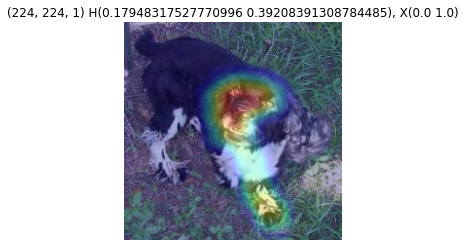

In [ ]:
ds = get_dataset(120, True)
imgs=0
for xb, hb, yb in ds:
  #imgs+=120
  #print(imgs)
  for x,h,y in zip(xb,hb,yb):
    print(x.dtype, y.dtype, x.shape)
    x = tf.cast(x, tf.float32).numpy()
    x -= x.min()
    x /= x.max()
  
    h = tf.cast(h, tf.float32).numpy()
  
    show(x)
    show(h, cmap='jet', alpha=0.3)
    print(imagenet_classes[np.argmax(y)])
    plt.title(f"{h.shape} H({h.mean()} {h.std()}), X({x.min()} {x.max()})")
    plt.axis('off')
    plt.show()
    print('\n\n\n')
    break
  break

In [ ]:
import time
from scipy.stats import spearmanr

DEBUG = False

def spearmanr_sim(explanations1, explanations2, reducers = [1, 4, 16]):
  sims = {k: [] for k in reducers}

  if explanations1.shape[-1] != 1:
    explanations1 = explanations1[:,:,:,None]
  if explanations2.shape[-1] != 1:
    explanations2 = explanations2[:,:,:,None]

  explanations1 = tf.cast(explanations1, tf.float32).numpy()
  explanations2 = tf.cast(explanations2, tf.float32).numpy()

  for reducer in reducers:
    sz = int(explanations1.shape[1] / reducer)
    explanations1_resize = tf.image.resize(explanations1, (sz, sz)).numpy()
    explanations2_resize = tf.image.resize(explanations2, (sz, sz)).numpy()

    
    if DEBUG:
      plt.subplot(1, 2, 1)
      show(explanations1_resize[0])
      plt.subplot(1, 2, 2)
      show(explanations2_resize[0])
      plt.show()
    
    for x1, x2 in zip(explanations1_resize, explanations2_resize):
        rho, _ = spearmanr(x1.flatten(), x2.flatten())
        sims[reducer].append(rho)

  return sims

def dice(explanations1, explanations2, reducers = [1, 4, 16], p = 10):
  dice_scores = {k: [] for k in reducers}

  if explanations1.shape[-1] != 1:
    explanations1 = explanations1[:,:,:,None]
  if explanations2.shape[-1] != 1:
    explanations2 = explanations2[:,:,:,None]

  explanations1 = tf.cast(explanations1, tf.float32).numpy()
  explanations2 = tf.cast(explanations2, tf.float32).numpy()

  for reducer in reducers:
    sz = int(explanations1.shape[1] / reducer)
    explanations1_resize = tf.image.resize(explanations1, (sz, sz)).numpy()
    explanations2_resize = tf.image.resize(explanations2, (sz, sz)).numpy()

    for j, (x1, x2) in enumerate(zip(explanations1_resize, explanations2_resize)):
      x1 = x1 > np.percentile(x1, 100-p, (0, 1))
      x2 = x2 > np.percentile(x2, 100-p, (0, 1))

      dice_score = 2.0 * np.sum(x1 * x2) / np.sum(x1 + x2)
      dice_scores[reducer].append(dice_score)
      
      if DEBUG and j == 0:
        plt.subplot(1, 2, 1)
        show(x1)
        plt.subplot(1, 2, 2)
        show(x2)
        plt.title(dice_score)
        plt.show()
  
  return dice_scores

def iou(explanations1, explanations2, reducers = [1, 4, 16], p = 10):
  iou_scores = {k: [] for k in reducers}

  if explanations1.shape[-1] != 1:
    explanations1 = explanations1[:,:,:,None]
  if explanations2.shape[-1] != 1:
    explanations2 = explanations2[:,:,:,None]

  explanations1 = tf.cast(explanations1, tf.float32).numpy()
  explanations2 = tf.cast(explanations2, tf.float32).numpy()

  for reducer in reducers:
    sz = int(explanations1.shape[1] / reducer)
    explanations1_resize = tf.image.resize(explanations1, (sz, sz)).numpy()
    explanations2_resize = tf.image.resize(explanations2, (sz, sz)).numpy()

    for j, (x1, x2) in enumerate(zip(explanations1_resize, explanations2_resize)):
      x1 = x1 > np.percentile(x1, 100-p, (0, 1))
      x2 = x2 > np.percentile(x2, 100-p, (0, 1))

      iou_inter = np.sum(np.logical_and(x1, x2))
      iou_union = np.sum(np.logical_or(x1, x2))

      iou_score = iou_inter / iou_union

      iou_scores[reducer].append(iou_score)
      
      if DEBUG and j == 0:
        plt.subplot(1, 2, 1)
        show(x1)
        plt.subplot(1, 2, 2)
        show(x2)
        plt.title(dice_score)
        plt.show()
  
  return iou_scores


In [ ]:
import modelvshuman
from modelvshuman import models
from modelvshuman.models.wrappers.pytorch import ClipPytorchModel
from modelvshuman.models.pytorch.clip.imagenet_classes import imagenet_classes
from modelvshuman.models.pytorch.clip.imagenet_templates import imagenet_templates
zoo = modelvshuman.models.pytorch.model_zoo
#model_name = 'clip'
#model = getattr(zoo, model_name)(model_name)

In [ ]:
from torch import autograd

def saliency(model, x, y_ohe,clip=False,zsw=None):
  #import pdb;pdb.set_trace()
  x.require_grad = True
  x.retain_grad()
 
  if clip:
    
    image_features = model.encode_image(x)
    image_features = image_features/image_features.norm(dim=-1, keepdim=True)
    logits = 100.*image_features@zsw
   
    #logits = model.forward_batch(x)
    y_pred = torch.sum(logits * y_ohe)
  else:
    inputs = model(x)
    y_pred = torch.sum(inputs * y_ohe)
  y_pred.backward()
  phi = x.grad
  
  return phi

def input_gradient(model, x, y):
  return saliency(model, x, y) * x

def smoothgrad(model, x, y, nb_samples=50, sigma=0.2):
  x_noisy = x.unsqueeze(1)
  x_noisy = x_noisy.repeat(1, nb_samples, 1, 1, 1)

  epsilon = torch.normal(torch.zeros(1, nb_samples, *x_noisy.shape[2:]), sigma).cuda()
  x_noisy = x_noisy + epsilon

  y_noisy = y.unsqueeze(1)
  y_noisy = y_noisy.repeat(1, nb_samples)

  sgs = None
  for i in range(len(x)):
    sg = torch.mean(saliency(model, x_noisy[i], y_noisy[i]), 0, keepdim=True)
    sgs = torch.cat([sgs, sg], 0) if sgs is not None else sg
  
  return sgs

def integrad(model, x, y, nb_samples=50):
  alphas = torch.linspace(0.0, 1.0, nb_samples)[None, :, None, None, None].cuda()

  x_integrated = x.unsqueeze(1)
  x_integrated = x_integrated.repeat(1, nb_samples, 1, 1, 1)
  x_integrated = x_integrated * alphas

  y_integrated = y.unsqueeze(1)
  y_integrated = y_integrated.repeat(1, nb_samples)

  igs = None
  for i in range(len(x)):
    ig = x[i] * torch.mean(saliency(model, x_integrated[i], y_integrated[i]), 0, keepdim=True)
    igs = torch.cat([igs, ig], 0) if igs is not None else ig
  
  return igs

explanation_methods = [saliency, input_gradient, smoothgrad, integrad]

In [ ]:
def _tf_to_torch(t):
  t = tf.cast(t, tf.float32).numpy()
  if t.shape[-1] in [1, 3]:
    t = np.moveaxis(t, -1, 1)
  
  t = torch.tensor(t, requires_grad = True).cuda()

  return t

def _torch_to_tf(t):
  try:
    t = t.detach()
  except:
    pass
  try:
    t = t.cpu()
  except:
    pass
  try:
    t = t.numpy()
  except:
    pass
  t = np.array(t)
  if t.shape[1] in [1, 3]:
    t = np.moveaxis(t, 1, -1)
  
  t = np.array(t, np.float32)

  return t

In [ ]:
def find_last_conv_layer(model):
  last_conv = None

  modules_to_look = []
  for module_key in list(model._modules.keys())[::-1]:
    modules_to_look.append((model, module_key, []))

  while len(modules_to_look):
    base_module, module_key, path = modules_to_look.pop(0)
    module = base_module._modules[module_key]

    sub_modules = module._modules
    
    if not len(sub_modules):
      # a layer
      if module.__class__.__name__ == 'Conv2d' and module.out_channels > 1_000:
        print('found', path, module_key)
        return module
    else:
      for next_key in list(module._modules.keys()):
        modules_to_look = [(module, next_key, path + [module_key])] + modules_to_look
  
  # no conv found
  print('[ERROR] not found!')
  return False


# Only Grad-CAM and Saliency

In [ ]:
!rm -rf *.csv

In [ ]:
models.list_models("pytorch").index('clip')

61

In [ ]:
from captum.attr import *

zoo = modelvshuman.models.pytorch.model_zoo
BATCH_SIZE = 16

list_models = models.list_models("pytorch")
#list_models = [ m for m  in list_models if 'bagnet17' not in m and 'bagnet33' not in m and 'resnet50' not in m  ]
for MODEL_NAME in list_models:#models.list_models("pytorch")[60:]:
  print(MODEL_NAME)
  model = getattr(zoo, MODEL_NAME)(MODEL_NAME)
  
  model = model.model.cuda()

  !rm -rf explanations
  !mkdir explanations

  RESULTS = []
  img_passed = 0
  ds = get_dataset(BATCH_SIZE, True)
  REDUCERS = [1, 4, 16]

  last_conv = find_last_conv_layer(model)
  gc_explainer = LayerGradCam(model, last_conv)
  ig = IntegratedGradients(model)
  sa_explainer = Saliency(model)
  sg_explainer = NoiseTunnel(sa_explainer)
  oc_explainer = Occlusion(model)

  for x_batch, h_batch, y_batch in ds:

    x_batch = _tf_to_torch(x_batch)
    y_batch = _tf_to_torch(y_batch)
    y_ohe   = torch.argmax(y_batch, axis=-1)

    sa_phi = saliency(model, x_batch, y_batch)
    gi_phi = sa_phi * x_batch
    #ig_phi = ig.attribute(x_batch, target = y_ohe, internal_batch_size = BATCH_SIZE // 2, n_steps = 30)
    #sg_phi = sg_explainer.attribute(x_batch, nt_type='smoothgrad', stdevs=5.0, nt_samples=50, target=y_ohe, nt_samples_batch_size = BATCH_SIZE // 2)
    #oc_phi = oc_explainer.attribute(x_batch, (3, 40, 40), (3, 20, 20), 0.0, target = y_ohe)

    sa_phi = torch.abs(torch.mean(sa_phi, axis=1))
    gi_phi = torch.abs(torch.mean(gi_phi, axis=1))
    #ig_phi = torch.abs(torch.mean(ig_phi, axis=1))
    #sg_phi = torch.abs(torch.mean(sg_phi, axis=1))
    #oc_phi = torch.mean(oc_phi, axis=1)

    gc_phi = gc_explainer.attribute(x_batch, y_ohe)
    gc_phi = _torch_to_tf(gc_phi)
    gc_phi = tf.image.resize(gc_phi, (224, 224)).numpy()

    label = _torch_to_tf(y_batch)
    label = np.argmax(label, -1)

    for phi_name, phi in [
                          ('saliency', sa_phi), 
                          ('gradinput', gi_phi), 
                          ('gradcam', gc_phi), 
                          #('integrad', ig_phi), 
                          #('smoothgrad', sg_phi), 
                          #('occlusion', oc_phi)
                          ]:

      dice_score = dice(_torch_to_tf(phi), h_batch, reducers = REDUCERS)
      spearman_score = spearmanr_sim(_torch_to_tf(phi), h_batch, reducers = REDUCERS)
      iou_score = iou(_torch_to_tf(phi), h_batch, reducers = REDUCERS)

      # saving scores
      for metric_name, scores in [('dice', dice_score), ('spearman', spearman_score), ('iou', iou_score)]:
        for reducer_key in REDUCERS:
          for img_i in range(len(scores[reducer_key])):
            img_id = img_passed + img_i
            RESULTS.append((MODEL_NAME, phi_name, img_id, label[img_i], metric_name, reducer_key, scores[reducer_key][img_i].astype(np.float16)))
      
      # saving explanations
      phi = _torch_to_tf(phi)
      for pid, p in enumerate(phi):
        p -= p.min()
        p /= p.max()
        p *= 255.0

        img_id = pid + img_passed
        cv2.imwrite(f"explanations/{MODEL_NAME}_{phi_name}_{img_id}_{label[pid]}.png",  p.astype(np.uint8))
      
      """
      set_size(10, 4)
      
      for i in range(3):
        plt.subplot(1, 2, 1)
        show(x_batch[i])
        show(phi[i], cmap='jet', p=1, smooth=3.0, alpha=0.35)
        
        plt.subplot(1, 2, 2)
        show(x_batch[i])
        show(h_batch[i], p=False, smooth=False, cmap='jet', alpha=0.35)
        plt.title(phi_name)    
        plt.show()
      """
    img_passed += len(x_batch)
    print(MODEL_NAME, img_passed)

  bucket_name = "serrelab/prj_metapredictor"

  res = pd.DataFrame(RESULTS, columns=[
                                      'model name', 
                                      'attribution name',
                                      'image_id',
                                      'label',
                                      'metric_name',
                                      'reducer',
                                      'metric_score'
  ])
  file_name = f'{MODEL_NAME}_results.csv'
  res.to_csv(file_name)

  !gsutil cp {file_name} gs://{bucket_name}/
  !gsutil -m -q cp -r explanations gs://{bucket_name}/ 
  # add quiet mode (-q)

  print('\n\n\n Done for ', MODEL_NAME, '\n\n\n')


bagnet9


Downloading: "https://bitbucket.org/wielandbrendel/bag-of-feature-pretrained-models/raw/249e8fa82c0913623a807d9d35eeab9da7dcc2a8/bagnet8-34f4ccd2.pth.tar" to /root/.cache/torch/hub/checkpoints/bagnet8-34f4ccd2.pth.tar


KeyboardInterrupt: ignored

In [ ]:
 del model


In [ ]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [ ]:
from captum.attr import *

zoo = modelvshuman.models.pytorch.model_zoo
BATCH_SIZE = 1
models_clip = [
'ViT-B/16','ViT-B/32',
 'RN50x64',
 'ViT-L/14@336px']
!rm -rf explanations
!mkdir explanations 
for MODEL_NAME in models_clip :
  #if 'clipR' not in MODEL_NAME:
  #  continue 
  print(MODEL_NAME)
  #model = getattr(zoo, MODEL_NAME)(MODEL_NAME)
  #zeroshot_weights = model.zeroshot_weights
  model,preprocess = clip.load(MODEL_NAME)
  zeroshot_weights = zeroshot_classifier(imagenet_classes, imagenet_templates,model)
  model = model.cuda()

  

  RESULTS = []
  scores_acc = []
  img_passed = 0
  ds = get_dataset(BATCH_SIZE, True)
  REDUCERS = [1, 4, 16]

  last_conv = find_last_conv_layer(model)
  gc_explainer = LayerGradCam(model, last_conv)
  ig = IntegratedGradients(model)
  sa_explainer = Saliency(model)
  sg_explainer = NoiseTunnel(sa_explainer)
  oc_explainer = Occlusion(model)

  for x_batch, h_batch, y_batch in ds:
    
    x_batch = _tf_to_torch(x_batch)
    x_batch = x_batch-x_batch.min()
    x_batch = x_batch/x_batch.max()
    y_batch = _tf_to_torch(y_batch)
    y_ohe   = torch.argmax(y_batch, axis=-1)
    
    
    #sa_phi = saliency(model, x_batch, y_batch)
    sa_phi = saliency(model, x_batch, y_batch,clip=True,zsw = zeroshot_weights)
    gi_phi = sa_phi * x_batch
    #ig_phi = ig.attribute(x_batch, target = y_ohe, internal_batch_size = BATCH_SIZE // 2, n_steps = 30)
    #sg_phi = sg_explainer.attribute(x_batch, nt_type='smoothgrad', stdevs=5.0, nt_samples=50, target=y_ohe, nt_samples_batch_size = BATCH_SIZE // 2)
    #oc_phi = oc_explainer.attribute(x_batch, (3, 40, 40), (3, 20, 20), 0.0, target = y_ohe)

    sa_phi = torch.abs(torch.mean(sa_phi, axis=1))
    gi_phi = torch.abs(torch.mean(gi_phi, axis=1))
    #ig_phi = torch.abs(torch.mean(ig_phi, axis=1))
    #sg_phi = torch.abs(torch.mean(sg_phi, axis=1))
    #oc_phi = torch.mean(oc_phi, axis=1)

    #gc_phi = gc_explainer.attribute(x_batch, y_ohe)
    #gc_phi = _torch_to_tf(gc_phi)
    #gc_phi = tf.image.resize(gc_phi, (224, 224)).numpy()

    label = _torch_to_tf(y_batch)
    label = np.argmax(label, -1)

    # Checking accuracy
    image_features = model.encode_image(x_batch)
    image_features = image_features/image_features.norm(dim=-1, keepdim=True)
    y_pred = 100.*image_features@zeroshot_weights
    #y_pred = model.forward_batch(x_batch)

    s = torch.argmax(y_pred, -1) == y_ohe
    for _s in s:
      scores_acc.append(_s.cpu().numpy())
    print('mean score of the model:',np.mean(scores_acc))

    for phi_name, phi in [
                          ('saliency', sa_phi), 
                          ('gradinput', gi_phi), 
                          #('gradcam', gc_phi), 
                          #('integrad', ig_phi), 
                          #('smoothgrad', sg_phi), 
                          #('occlusion', oc_phi)
                          ]:

      dice_score = dice(_torch_to_tf(phi), h_batch, reducers = REDUCERS)
      spearman_score = spearmanr_sim(_torch_to_tf(phi), h_batch, reducers = REDUCERS)
      iou_score = iou(_torch_to_tf(phi), h_batch, reducers = REDUCERS)

      # saving scores
      for metric_name, scores in [('dice', dice_score), ('spearman', spearman_score), ('iou', iou_score)]:
        for reducer_key in REDUCERS:
          for img_i in range(len(scores[reducer_key])):
            img_id = img_passed + img_i
            RESULTS.append((MODEL_NAME, phi_name, img_id, label[img_i], metric_name, reducer_key, scores[reducer_key][img_i]))
      
      # saving explanations
      phi = _torch_to_tf(phi)
      for pid, p in enumerate(phi):
        p -= p.min()
        p /= p.max()
        p *= 255.0

        img_id = pid + img_passed
        cv2.imwrite(f"explanations/{MODEL_NAME}_{phi_name}_{img_id}_{label[pid]}.png",  p.astype(np.uint8))
      
      """
      set_size(10, 4)
      
      for i in range(3):
        plt.subplot(1, 2, 1)
        show(x_batch[i])
        show(phi[i], cmap='jet', p=1, smooth=3.0, alpha=0.35)
        
        plt.subplot(1, 2, 2)
        show(x_batch[i])
        show(h_batch[i], p=False, smooth=False, cmap='jet', alpha=0.35)
        plt.title(phi_name)    
        plt.show()
      """
    img_passed += len(x_batch)
    print(MODEL_NAME, img_passed)

  bucket_name = "serrelab/prj_metapredictor"

  res = pd.DataFrame(RESULTS, columns=[
                                      'model name', 
                                      'attribution name',
                                      'image_id',
                                      'label',
                                      'metric_name',
                                      'reducer',
                                      'metric_score'
  ])
  file_name = f'{MODEL_NAME}_results.csv'
  res.to_csv(file_name)

  !gsutil cp {file_name} gs://{bucket_name}/

  # add quiet mode (-q)

  print('\n\n\n Done for ', MODEL_NAME, '\n\n\n')
!gsutil -m -q cp -r explanations gs://{bucket_name}/ 


ViT-B/16


100%|███████████████████████████████████████| 335M/335M [00:04<00:00, 87.6MiB/s]


  0%|          | 0/1000 [00:00<?, ?it/s]

Se truncaron las últimas líneas 5000 del resultado de transmisión.
mean score of the model: 0.649672131147541
ViT-B/16 6100
mean score of the model: 0.6497295525323717
ViT-B/16 6101
mean score of the model: 0.6497869550966896
ViT-B/16 6102
mean score of the model: 0.649844338849746
ViT-B/16 6103
mean score of the model: 0.6497378768020969
ViT-B/16 6104
mean score of the model: 0.6497952497952498
ViT-B/16 6105
mean score of the model: 0.6498526039960695
ViT-B/16 6106
mean score of the model: 0.6499099394137875
ViT-B/16 6107
mean score of the model: 0.6499672560576293
ViT-B/16 6108
mean score of the model: 0.6498608610247176
ViT-B/16 6109
mean score of the model: 0.6497545008183306
ViT-B/16 6110
mean score of the model: 0.6496481754213713
ViT-B/16 6111
mean score of the model: 0.649705497382199
ViT-B/16 6112
mean score of the model: 0.6497628005889089
ViT-B/16 6113
mean score of the model: 0.6498200850507033
ViT-B/16 6114
mean score of the model: 0.6498773507767784
ViT-B/16 6115
mean sco

In [ ]:
w

# All explanations

In [ ]:
from captum.attr import *

zoo = modelvshuman.models.pytorch.model_zoo
BATCH_SIZE = 32

for MODEL_NAME in models.list_models("pytorch"):
  if 'clipR' not in MODEL_NAME:
    continue 
  print(MODEL_NAME)
  modelclip = getattr(zoo, MODEL_NAME)(MODEL_NAME)
  zeroshot_weights = modelclip.zeroshot_weights
  model = modelclip.model.cuda()

  !rm -rf explanations
  !mkdir explanations

  RESULTS = []
  img_passed = 0
  ds = get_dataset(BATCH_SIZE, True)
  REDUCERS = [1, 4, 16]

  last_conv = find_last_conv_layer(model)
  gc_explainer = LayerGradCam(model, last_conv)
  ig = IntegratedGradients(model)
  sa_explainer = Saliency(model)
  sg_explainer = NoiseTunnel(sa_explainer)
  oc_explainer = Occlusion(model)

  for x_batch, h_batch, y_batch in ds:

    x_batch = _tf_to_torch(x_batch)
    y_batch = _tf_to_torch(y_batch)
    y_ohe   = torch.argmax(y_batch, axis=-1)

    sa_phi = saliency(model, x_batch, y_batch,clip=True,zsw = zeroshot_weights)
    gi_phi = sa_phi * x_batch
    ig_phi = ig.attribute(x_batch, target = y_ohe, internal_batch_size = BATCH_SIZE // 2, n_steps = 30)
    sg_phi = sg_explainer.attribute(x_batch, nt_type='smoothgrad', stdevs=5.0, nt_samples=50, target=y_ohe, nt_samples_batch_size = BATCH_SIZE // 2)
    oc_phi = oc_explainer.attribute(x_batch, (3, 40, 40), (3, 20, 20), 0.0, target = y_ohe)

    sa_phi = torch.abs(torch.mean(sa_phi, axis=1))
    gi_phi = torch.abs(torch.mean(gi_phi, axis=1))
    ig_phi = torch.abs(torch.mean(ig_phi, axis=1))
    sg_phi = torch.abs(torch.mean(sg_phi, axis=1))
    oc_phi = torch.mean(oc_phi, axis=1)

    gc_phi = gc_explainer.attribute(x_batch, y_ohe)
    gc_phi = _torch_to_tf(gc_phi)
    gc_phi = tf.image.resize(gc_phi, (224, 224)).numpy()

    label = _torch_to_tf(y_batch)
    label = np.argmax(label, -1)

    for phi_name, phi in [('saliency', sa_phi), ('gradinput', gi_phi), ('gradcam', gc_phi), 
                          ('integrad', ig_phi), ('smoothgrad', sg_phi), ('occlusion', oc_phi)]:

      dice_score = dice(_torch_to_tf(phi), h_batch, reducers = REDUCERS)
      spearman_score = spearmanr_sim(_torch_to_tf(phi), h_batch, reducers = REDUCERS)
      iou_score = iou(_torch_to_tf(phi), h_batch, reducers = REDUCERS)

      # saving scores
      for metric_name, scores in [('dice', dice_score), ('spearman', spearman_score), ('iou', iou_score)]:
        for reducer_key in REDUCERS:
          for img_i in range(len(scores[reducer_key])):
            img_id = img_passed + img_i
            RESULTS.append((MODEL_NAME, phi_name, img_id, label[img_i], metric_name, reducer_key, scores[reducer_key][img_i].astype(np.float16)))
      
      # saving explanations
      phi = _torch_to_tf(phi)
      for pid, p in enumerate(phi):
        p -= p.min()
        p /= p.max()
        p *= 255.0

        img_id = pid + img_passed
        cv2.imwrite(f"explanations/{MODEL_NAME}_{phi_name}_{img_id}_{label[pid]}.png",  p.astype(np.uint8))
      
      set_size(10, 4)
      
      for i in range(3):
        plt.subplot(1, 2, 1)
        show(x_batch[i])
        show(phi[i], cmap='jet', p=1, smooth=3.0, alpha=0.35)
        
        plt.subplot(1, 2, 2)
        show(x_batch[i])
        show(h_batch[i], p=False, smooth=False, cmap='jet', alpha=0.35)
        plt.title(phi_name)    
        plt.show()
    
    img_passed += len(x_batch)
    print(MODEL_NAME, img_passed)

  bucket_name = "serrelab/prj_metapredictor"

  res = pd.DataFrame(RESULTS, columns=[
                                      'model name', 
                                      'attribution name',
                                      'image_id',
                                      'label',
                                      'metric_name',
                                      'reducer',
                                      'metric_score'
  ])
  file_name = f'{MODEL_NAME}_results.csv'
  res.to_csv(file_name)

  !gsutil cp {file_name} gs://{bucket_name}/
  !gsutil -m cp -r explanations gs://{bucket_name}/ 

  print('\n\n\n Done for ', MODEL_NAME, '\n\n\n')


clipRN50


100%|███████████████████████████████████████| 244M/244M [00:04<00:00, 63.4MiB/s]
100%|██████████| 1000/1000 [1:21:49<00:00,  4.91s/it]


RuntimeError: ignored

In [ ]:
import pandas as pd

bucket_name = "serrelab/prj_metapredictor"
!gsutil cp results.csv gs://{bucket_name}/

res = pd.DataFrame(RESULTS, columns=[
                                     'model name', 
                                     'attribution name',
                                     'image_id',
                                     'label',
                                     'metric_name',
                                     'reducer',
                                     'metric_score'
])

res.to_csv('results.csv')

In [ ]:
!gsutil -m cp -r explanations gs://{bucket_name}/

In [ ]:
zoo = modelvshuman.models.pytorch.model_zoo
for model_name in models.list_models("pytorch"):
  if 'transformer' in model_name:
    continue
  if 'vit' in model_name:
    continue
  if 'BiTM' in model_name:
    continue
  try:
    model = getattr(zoo, model_name)(model_name)
    model = model.model
    gc_layer = find_last_conv_layer(model)
    gc_explainer = LayerGradCam(model, gc_layer)

    gc_phi = gc_explainer.attribute(x_batch.cpu(), torch.argmax(y_batch, axis=-1))
    print(model_name, 'loaded', gc_phi.shape)
    print('\n\n')
  except Exception as e:
    print('\n /!\ ERROR FOR ', model_name, ': ', e, '  /!\  \n\n')
    print(e)